C:\Users\PLN\AppData\Local\Temp\ipykernel_19040\3628120133.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_vehicles = df['Vehicles'].resample('H').sum()


Dataset size after initial processing and feature engineering: 14424
Train data: 11539 samples (2015-11-08 00:00:00 to 2017-03-02 18:00:00)
Test data: 2885 samples (2017-03-02 19:00:00 to 2017-06-30 23:00:00)
X_train_scaled shape: (11539, 16), y_train_scaled shape: (11539,)
X_test_scaled shape: (2885, 16)
Last 24h test segment size: 24 samples


Training and Predicting Models: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]



--- Evaluating on Full Test Set (Last 20%) ---

XGBoost Results (Full Test Set (Last 20%), 2885 points):
  MSE : 57.91
  RMSE: 7.61
  MAE : 5.23
  R2  : 0.90

--- Evaluating on Last 24 Hours of Test Set ---

XGBoost Results (Last 24h of Test Set, 24 points):
  MSE : 71.61
  RMSE: 8.46
  MAE : 6.89
  R2  : 0.84

--- Plotting Last 24 Hours of Test Set ---


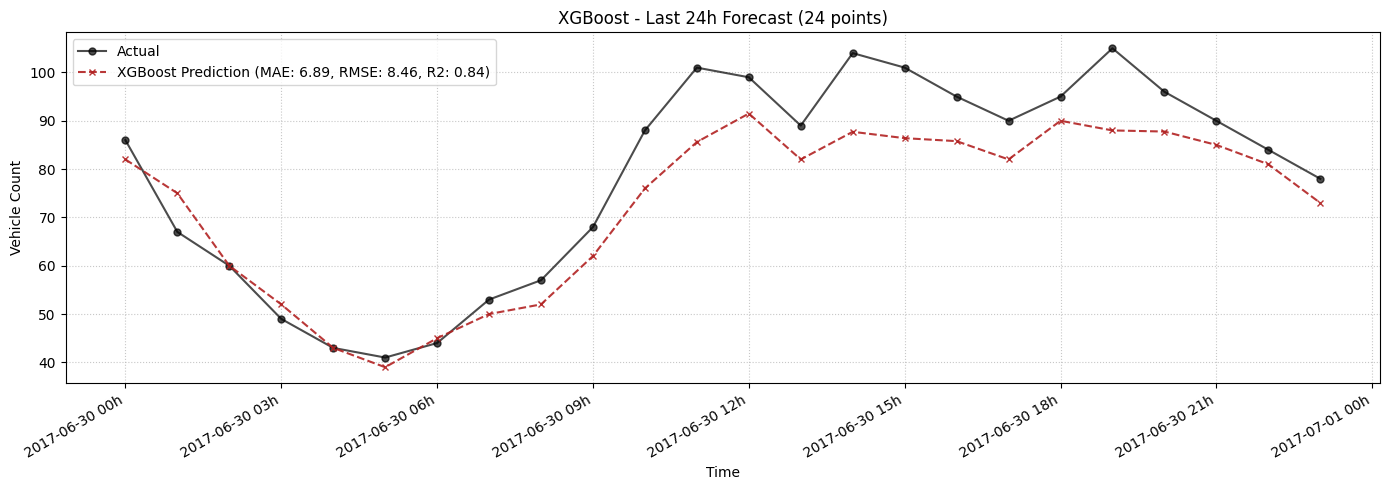


--- Model Ranking based on MAE (Last 24h of Test Set) ---
  XGBoost: 6.89

--- Model Ranking based on RMSE (Last 24h of Test Set) ---
  XGBoost: 8.46

--- Model Ranking based on R2 (Last 24h of Test Set) ---
  XGBoost: 0.84

--- Model Ranking based on MAE (Full Test Set (Last 20%)) ---
  XGBoost: 5.23

--- Model Ranking based on RMSE (Full Test Set (Last 20%)) ---
  XGBoost: 7.61

--- Model Ranking based on R2 (Full Test Set (Last 20%)) ---
  XGBoost: 0.90

--- Processing Complete ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Added r2_score
from sklearn.preprocessing import StandardScaler, QuantileTransformer
# Keras imports are present but not used in the provided model dictionary.
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
from tqdm import tqdm # Add tqdm for progress bars
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=FutureWarning, module="lightgbm")


# 📄 Load & preprocess
df = pd.read_csv("traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df[df['Junction'] == 1].copy() # Filter for Junction 1
df.set_index('DateTime', inplace=True)
df.sort_index(inplace=True)
hourly_vehicles = df['Vehicles'].resample('H').sum()

# 🧠 Feature engineering
data = pd.DataFrame(hourly_vehicles)
data['lag_1'] = data['Vehicles'].shift(1)
data['lag_24'] = data['Vehicles'].shift(24)
data['lag_48'] = data['Vehicles'].shift(48)
data['lag_168'] = data['Vehicles'].shift(168) # Corresponds to 7 days
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['day'] = data.index.day # Day of month
data['month'] = data.index.month
data['hour_sin'] = np.sin(2*np.pi*data['hour']/24)
data['hour_cos'] = np.cos(2*np.pi*data['hour']/24)
data['dow_sin'] = np.sin(2*np.pi*data['day_of_week']/7)
data['dow_cos'] = np.cos(2*np.pi*data['day_of_week']/7)
data['month_sin'] = np.sin(2*np.pi*data['month']/12)
data['month_cos'] = np.cos(2*np.pi*data['month']/12)
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['is_workday'] = (~data['is_weekend'].astype(bool)).astype(int)
data['morning_rush'] = ((data['hour'] >= 7) & (data['hour'] <= 9)).astype(int)
data['evening_rush'] = ((data['hour'] >= 16) & (data['hour'] <= 19)).astype(int)
data['is_rush_hour'] = ((data['morning_rush'] | data['evening_rush']) & data['is_workday']).astype(int)
data.dropna(inplace=True)
print(f"Dataset size after initial processing and feature engineering: {len(data)}")

# 🔧 Define Features
features = [
    'lag_1', 'lag_24', 'lag_48', 'lag_168',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    'month_sin', 'month_cos', 'is_weekend', 'day',
    'morning_rush', 'evening_rush', 'is_rush_hour', 'is_workday'
]
target_col = 'Vehicles'

# ⏳ Split data: 80% train, 20% test
n_total = len(data)
if n_total < 24 + 5: # Min for 24h test and some training
    raise ValueError(f"Insufficient data after processing ({n_total} rows). Need more data for robust train/test split.")

train_size_ratio = 0.80
train_n = int(n_total * train_size_ratio)
test_n = n_total - train_n

if test_n == 0:
    raise ValueError(f"Test set has 0 samples. Adjust train_size_ratio or check data. Total samples: {n_total}")

train_df = data.iloc[:train_n]
test_df = data.iloc[train_n:]

print(f"Train data: {len(train_df)} samples ({train_df.index.min()} to {train_df.index.max()})")
print(f"Test data: {len(test_df)} samples ({test_df.index.min()} to {test_df.index.max()})")

# 🔧 Initialize Scalers
feature_scaler = StandardScaler()
# Ensure n_quantiles is not more than the number of samples in training data
n_quantiles_val = min(1000, len(train_df))
if n_quantiles_val == 0:
    raise ValueError("Training data is empty, cannot fit QuantileTransformer.")
target_scaler = QuantileTransformer(output_distribution='normal', n_quantiles=n_quantiles_val)

# Fit scalers ONLY on training data
X_train_features = train_df[features]
y_train_target = train_df[target_col].values.reshape(-1, 1)

X_train_scaled = feature_scaler.fit_transform(X_train_features)
y_train_scaled = target_scaler.fit_transform(y_train_target).flatten()
print(f"X_train_scaled shape: {X_train_scaled.shape}, y_train_scaled shape: {y_train_scaled.shape}")

# Transform test data using FITTED scalers
X_test_features = test_df[features]
y_test_actual_full = test_df[target_col].values # Original scale for final comparison

X_test_scaled = feature_scaler.transform(X_test_features)
print(f"X_test_scaled shape: {X_test_scaled.shape}")

# Timestamps for the full test set
timestamps_test_full = test_df.index

# Prepare for "last 24 hours of test set" evaluation
num_test_points_full = len(test_df)
eval_24h_horizon = 24
last_n_test_points = min(eval_24h_horizon, num_test_points_full)

if last_n_test_points > 0:
    X_test_last_n_scaled = X_test_scaled[-last_n_test_points:]
    y_test_actual_last_n = y_test_actual_full[-last_n_test_points:]
    timestamps_last_n = timestamps_test_full[-last_n_test_points:]
    print(f"Last {last_n_test_points}h test segment size: {len(X_test_last_n_scaled)} samples")
else:
    print("Warning: Test set is too short to extract a 'last N hours' segment for detailed evaluation.")
    X_test_last_n_scaled = np.array([])
    y_test_actual_last_n = np.array([])
    timestamps_last_n = pd.Index([])


# 🤖 Train models
models = {
    # "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    # "SVR": SVR(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    # "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    # "LightGBM": LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1),
    # "KNN": KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
    # "MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42, early_stopping=True, n_iter_no_change=10)
}

predictions_full_test = {}
predictions_last_n_test = {}

for name, model in tqdm(models.items(), desc="Training and Predicting Models"):
    model.fit(X_train_scaled, y_train_scaled)

    # Predict on the full test set
    y_pred_scaled_full = model.predict(X_test_scaled)
    y_pred_full = target_scaler.inverse_transform(y_pred_scaled_full.reshape(-1, 1)).flatten()
    predictions_full_test[name] = np.clip(y_pred_full, 0, None) # Clip to non-negative

    # Predict on the last N hours of the test set
    if len(X_test_last_n_scaled) > 0:
        y_pred_scaled_last_n = model.predict(X_test_last_n_scaled)
        y_pred_last_n = target_scaler.inverse_transform(y_pred_scaled_last_n.reshape(-1, 1)).flatten()
        predictions_last_n_test[name] = np.clip(y_pred_last_n, 0, None)
    else:
        predictions_last_n_test[name] = np.array([])

# 🧪 Evaluation
def evaluate(y_true, y_pred, model_name, segment_label):
    if len(y_true) == 0 or len(y_pred) == 0 :
        print(f"\n{model_name} Results ({segment_label}): Not enough data to evaluate (True: {len(y_true)}, Pred: {len(y_pred)}).")
        return {'MAE': np.nan, 'RMSE': np.nan, 'MSE': np.nan, 'R2': np.nan}
    if len(y_true) != len(y_pred):
        print(f"\n{model_name} Results ({segment_label}): Length mismatch (True: {len(y_true)}, Pred: {len(y_pred)}). Skipping.")
        return {'MAE': np.nan, 'RMSE': np.nan, 'MSE': np.nan, 'R2': np.nan}

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{model_name} Results ({segment_label}, {len(y_true)} points):")
    print(f"  MSE : {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R2  : {r2:.2f}")
    return {'MAE': mae, 'RMSE': rmse, 'MSE': mse, 'R2': r2}

all_metrics_full_test = {}
all_metrics_last_n_test = {}

print("\n--- Evaluating on Full Test Set (Last 20%) ---")
for model_name, preds_full in predictions_full_test.items():
    metrics = evaluate(y_test_actual_full, preds_full, model_name, "Full Test Set (Last 20%)")
    all_metrics_full_test[model_name] = metrics

print(f"\n--- Evaluating on Last {last_n_test_points} Hours of Test Set ---")
for model_name, preds_last_n in predictions_last_n_test.items():
    if len(preds_last_n) > 0: # Only evaluate if predictions were made for this segment
        metrics = evaluate(y_test_actual_last_n, preds_last_n, model_name, f"Last {last_n_test_points}h of Test Set")
        all_metrics_last_n_test[model_name] = metrics
    else:
        all_metrics_last_n_test[model_name] = {'MAE': np.nan, 'RMSE': np.nan, 'MSE': np.nan, 'R2': np.nan}


# 📊 Visualization
def plot_forecast(index, actual, preds, model_name, color, segment_label, metrics=None):
    if len(index) == 0 or len(actual) == 0 or len(preds) == 0:
        print(f"Skipping plot for {model_name} ({segment_label}) due to empty data.")
        return
    plt.figure(figsize=(14, 5)) # Adjusted size
    plt.plot(index, actual, label='Actual', color='black', marker='o', linestyle='-', markersize=5, alpha=0.7)
    
    metric_str = ""
    if metrics:
        metric_str = f" (MAE: {metrics.get('MAE', np.nan):.2f}, RMSE: {metrics.get('RMSE', np.nan):.2f}, R2: {metrics.get('R2', np.nan):.2f})"
        
    plt.plot(index, preds, label=f'{model_name} Prediction{metric_str}', color=color, marker='x', linestyle='--', markersize=5, alpha=0.9)
    plt.title(f'{model_name} - {segment_label} Forecast ({len(index)} points)')
    plt.xlabel('Time')
    plt.ylabel('Vehicle Count')
    plt.xticks(rotation=30, ha='right') # Adjusted rotation
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %Hh'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=max(1,len(index)//6), maxticks=10)) # Dynamic ticks
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 🎨 Color mapping
colors = {
    "Random Forest": "royalblue", "SVR": "forestgreen", "XGBoost": "firebrick",
    "Gradient Boosting": "darkorange", "LightGBM": "saddlebrown", "KNN": "darkcyan",
    "MLP Regressor": "mediumorchid",
}

# 🚀 Run plotting for the last N hours segment
print(f"\n--- Plotting Last {last_n_test_points} Hours of Test Set ---")
if len(timestamps_last_n) > 0:
    for model_name, preds_last_n in predictions_last_n_test.items():
        if len(preds_last_n) > 0: # Ensure there are predictions for this segment
            current_metrics = all_metrics_last_n_test.get(model_name)
            plot_forecast(timestamps_last_n, y_test_actual_last_n, preds_last_n,
                          model_name, colors.get(model_name, 'gray'), f"Last {last_n_test_points}h", metrics=current_metrics)
        else:
            print(f"No predictions to plot for {model_name} (Last {last_n_test_points}h).")
else:
    print(f"No data to plot for the 'Last {last_n_test_points} Hours' segment.")


# Model Ranking
def print_ranking(metrics_dict, metric_name, segment_description, higher_is_better=False):
    print(f"\n--- Model Ranking based on {metric_name} ({segment_description}) ---")
    valid_scores = {name: scores[metric_name] for name, scores in metrics_dict.items()
                    if isinstance(scores, dict) and metric_name in scores and not np.isnan(scores[metric_name])}
    if not valid_scores:
        print(f"No models with valid {metric_name} scores for ranking in this segment.")
        return
    # Sort: if higher_is_better is True, sort descending; otherwise, ascending.
    for name, score in sorted(valid_scores.items(), key=lambda x: x[1], reverse=higher_is_better):
        print(f"  {name}: {score:.2f}")

# Ranking for the "Last N Hours" segment
if last_n_test_points > 0 :
    print_ranking(all_metrics_last_n_test, 'MAE', f"Last {last_n_test_points}h of Test Set")
    print_ranking(all_metrics_last_n_test, 'RMSE', f"Last {last_n_test_points}h of Test Set")
    print_ranking(all_metrics_last_n_test, 'R2', f"Last {last_n_test_points}h of Test Set", higher_is_better=True)

# Ranking for the "Full Test Set (Last 20%)"
print_ranking(all_metrics_full_test, 'MAE', "Full Test Set (Last 20%)")
print_ranking(all_metrics_full_test, 'RMSE', "Full Test Set (Last 20%)")
print_ranking(all_metrics_full_test, 'R2', "Full Test Set (Last 20%)", higher_is_better=True)

print("\n--- Processing Complete ---")